In [144]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform, gamma

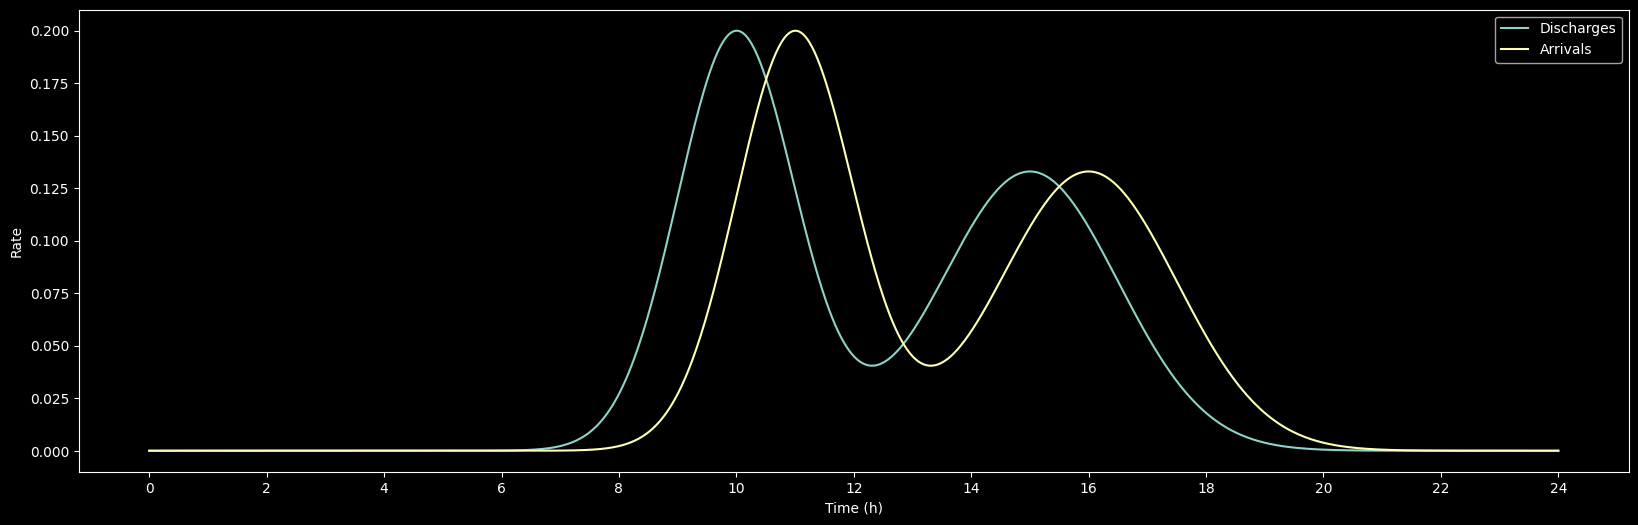

In [145]:
p_ = 0.55
t_ = np.linspace(0, 24, 1000)

class ArrivalDistribution:
    first_round_time = 9
    second_round_time = 15
    def __init__(self, p=0.5, offset=0):
        self.p = p
        self.first_peak = norm(loc=10 + offset, scale=1)
        self.second_peak = norm(loc=15 + offset, scale=1.5)

    def pdf(self, x):
        return self.p * self.first_peak.pdf(x) + (1 - self.p) * self.second_peak.pdf(x)

    def rvs(self, size=()):
        s1 = self.first_peak.rvs(size=size)
        s2 = self.second_peak.rvs(size=size)
        choice = uniform.rvs(size=size) < self.p
        return np.where(choice, s1, s2)

discharge_dist = ArrivalDistribution()
admission_dist = ArrivalDistribution(offset=1)


fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(t_, discharge_dist.pdf(t_), label="Discharges")
ax.plot(t_, admission_dist.pdf(t_), label="Arrivals")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Rate")
ax.set_xticks(np.arange(0, 25, 2), np.arange(0, 25, 2))
ax.legend()
plt.show()

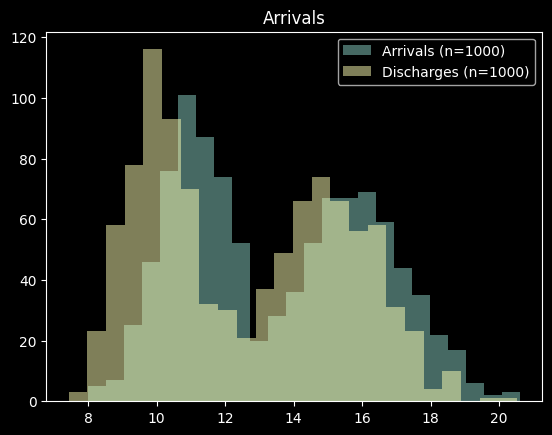

In [146]:
arrivals = admission_dist.rvs(size=1000)
discharges = discharge_dist.rvs(size=1000)

plt.title("Arrivals")
plt.hist(arrivals, alpha=0.5, bins=24, label=f"Arrivals (n={len(arrivals)})")
plt.hist(discharges, alpha=0.5, bins=24, label=f"Discharges (n={len(discharges)})")
plt.legend()
plt.show()

In [147]:
from heapq import heapify, heappop, heappush
from dataclasses import dataclass
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tqdm import tqdm

## Timeline of a bed
All the while the bed may have to wait for available transport and washing. 
- Patient is admitted to the hospital and occupies a bed.
- Patient is discharged, and the bed is sent to the logistics floor.
- Bed is transported from the elevator to the washing area.
- Bed is washed.
- Bed is transported back to the elevator.

In [148]:
from datetime import timedelta
from enum import IntEnum

class Buffer(IntEnum):
    DIRTY = 0
    CLEAN = 1

def decorate_event(cls):
    return dataclass(slots=True, frozen=True)(cls)

@decorate_event
class Event:
    time: float

    def __lt__(self, other):
        return self.time < other.time
    
    # __repr__ didnt work
    def print(self):
        total_seconds = int(self.time * 3600)
        hours, remainder = divmod(total_seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"[{hours:02}:{minutes:02}:{seconds:02}] {self}")


@decorate_event
class PatientArrived(Event):
    pass


@decorate_event
class PatientDischarged(Event):
    pass


@decorate_event
class BedArrivedElevator(Event):
    elevator_id: int
    buffer: Buffer

@decorate_event
class BedArrivedWashing(Event):
    pass

@decorate_event
class BedStartedWashing(Event):
    pass

@decorate_event
class BedFinishedWashing(Event):
    pass

@decorate_event
class RobotsUpdated(Event):
    pass

@decorate_event
class PickUpBed(Event):
    robot_id: int
    location_id: int
    buffer: Buffer

@decorate_event
class DropOffBed(Event):
    robot_id: int
    location_id: int
    buffer: Buffer


In [149]:
def simulate_system(
        discharge_dist : callable,
        arrival_dist: callable,
        service_time_dist : callable,
        transport_time_dist : callable,
        distance_matrix: np.ndarray,
        n_patients: int = 200,

    ):

    # 0 = washer
    # 1 = elevator 1
    # 2 = elevator 2
    # ...
    n_elevators = 1
    n_robots = 2
    robot_speed = 1.4

    buffers = np.zeros((2, 1 + n_elevators))
    reserved = np.zeros_like(buffers)
    demand = np.zeros(1 + n_elevators) # index 0 never used, but keeps indexing consistent

    mean_time = distances / robot_speed

    robot_location = np.zeros(n_robots, dtype=int)
    robot_traveling = np.zeros(n_robots, dtype=bool)
    robot_beds = np.zeros(n_robots, dtype=bool)

    arrival_weights = np.ones(n_elevators) / n_elevators
    discharge_weights = np.ones(n_elevators) / n_elevators

    discharge_times = discharge_dist.rvs(size=n_patients)
    arrival_times = arrival_dist.rvs(size=n_patients)

    events = [PatientDischarged(time) for time in discharge_times]
    events += [PatientArrived(time) for time in arrival_times]
    heapify(events)

    events_processed = []
    buffer_list = [buffers.copy()]
    demand_list = [demand.copy()]
    times = [0.0]

    washer_ready = True

    iterations = 0
    while events:
        iterations += 1
        if iterations > 10000:
            break

        event = heappop(events)
        event.print()

        match event:
            case PatientArrived(time=t):
                eid = np.random.choice(n_elevators, p=arrival_weights) + 1
                if buffers[Buffer.CLEAN, eid] > 0:
                    buffers[Buffer.CLEAN, eid] -= 1
                else:
                    demand[eid] += 1

            case PatientDischarged(time=t):
                eid = np.random.choice(n_elevators, p=discharge_weights) + 1
                heappush(events, BedArrivedElevator(t, eid, Buffer.DIRTY))
            
            case BedArrivedElevator(time=t, elevator_id=eid, buffer=buffer):
                buffers[buffer, eid] += 1
                heappush(events, RobotsUpdated(t))
        
            case BedArrivedWashing(time=t):
                # If washer ready, start washing immediately 
                if washer_ready:
                    heappush(events, BedStartedWashing(t))
                
            case BedStartedWashing(time=t):
                buffers[Buffer.DIRTY, 0] -= 1
                washer_ready = False
                heappush(events, BedFinishedWashing(t + service_time_dist()))

            case BedFinishedWashing(time=t):
                buffers[Buffer.CLEAN, 0] += 1

                heappush(events, RobotsUpdated(t))

                washer_ready = True

                # If washer is ready and there are beds waiting outside
                if buffers[Buffer.DIRTY, 0] > 0:
                    heappush(events, BedStartedWashing(t))
                
            
            case RobotsUpdated(time=t):
                available_robots = np.where(~robot_traveling)[0]
                for robot_id in available_robots:
                    dispatched = False
                    available_beds = buffers - reserved
                    # handle dirty beds first
                    if np.any(available_beds[Buffer.DIRTY, 1:] != 0):
                        location_id = np.argmax(available_beds[Buffer.DIRTY, 1:]) + 1
                        robot_traveling[robot_id] = True

                        reserved[Buffer.DIRTY, location_id] += 1

                        transport_time = transport_time_dist(distance_matrix[robot_location[robot_id], location_id])
                        heappush(events, PickUpBed(t + transport_time, robot_id, location_id, Buffer.DIRTY))    
                        dispatched = True

                    if not dispatched and available_beds[Buffer.CLEAN, 0] != 0:
                        location_id = 0
                        robot_traveling[robot_id] = True

                        reserved[Buffer.CLEAN, location_id] += 1

                        transport_time = transport_time_dist(distance_matrix[robot_location[robot_id], location_id])
                        heappush(events, PickUpBed(t + transport_time, robot_id, location_id, Buffer.CLEAN))
                    #print(robot_location)
                    #print(buffers)

            case PickUpBed(time=t, robot_id=robid, location_id=locid, buffer=buffer):
                assert buffers[buffer, locid] > 0, "Must have beds to pick up!"
                buffers[buffer, locid] -= 1
                reserved[buffer, locid] -= 1
                robot_location[robid] = locid
                robot_beds[robid] = True

                if buffer == Buffer.DIRTY:
                    target_location = 0
                else:
                    expected_time_to_depletion = buffers[Buffer.CLEAN, 1:] / arrival_weights
                    min_time = np.min(expected_time_to_depletion)

                    indices = np.where(expected_time_to_depletion == min_time)[0]
                    target_location = np.random.choice(indices) + 1

                transport_time = transport_time_dist(distance_matrix[locid, target_location])

                heappush(events, DropOffBed(t + transport_time, robid, target_location, buffer))

            case DropOffBed(time=t, robot_id=robid, location_id=locid, buffer=buffer):
                assert robot_beds[robid], "Robots must have bed to drop off"
                
                buffers[buffer, locid] += 1
                robot_location[robid] = locid
                robot_beds[robid] = False
                robot_traveling[robid] = False

                if locid == 0: # dropped off at washer
                    heappush(events, BedArrivedWashing(t))
                else: # dropped off at elevator
                    if demand[locid] > 0:
                        buffers[buffer, locid] -= 1
                        demand[locid] -= 1

                heappush(events, RobotsUpdated(t))

            case _:
                raise ValueError("Unknown event type!")

        buffer_list.append(buffers.copy())
        demand_list.append(demand.copy())
        times.append(event.time)

        verbose = True
        if verbose:
            print("Buffers")
            print(buffers)
            print("Demand")
            print(demand)
            print("Robots")
            print(robot_location)
            print(robot_traveling)   
            print()         

        events_processed.append(event)

    data = {
        "buffers": np.stack(buffer_list, axis=-1),
        "demands": np.stack(demand_list, axis=-1),
        "times": np.array(times),
        "arrivals": arrival_times,
        "discharges": discharge_times,
    }

    return events_processed, data

np.random.seed(42069)



def service_time_dist():
    service_min_time = 5/60
    return service_min_time + expon(scale=1/60).rvs()


def transport_time_dist(distance_meters):
    if distance_meters == 0:
        return 0
    speed_meters_per_second = 1.4
    transport_time_seconds = gamma(a=distance_meters, scale=1/speed_meters_per_second).rvs()
    return transport_time_seconds / 3600

distances = np.array([
    [10, 175],
    [175, 10],
])

events, data = simulate_system(discharge_dist, admission_dist, service_time_dist, transport_time_dist, distances, n_patients=100)

[07:52:05] PatientDischarged(time=np.float64(7.868147729897972))
Buffers
[[0. 0.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0 0]
[False False]

[07:52:05] BedArrivedElevator(time=np.float64(7.868147729897972), elevator_id=1, buffer=<Buffer.DIRTY: 0>)
Buffers
[[0. 1.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0 0]
[False False]

[07:52:05] RobotsUpdated(time=np.float64(7.868147729897972))
Buffers
[[0. 1.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0 0]
[ True False]

[07:54:03] PickUpBed(time=np.float64(7.901061569918924), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.DIRTY: 0>)
Buffers
[[0. 0.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[1 0]
[ True False]

[07:56:12] DropOffBed(time=np.float64(7.9369085442584195), robot_id=np.int64(0), location_id=0, buffer=<Buffer.DIRTY: 0>)
Buffers
[[1. 0.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0 0]
[False False]

[07:56:12] BedArrivedWashing(time=np.float64(7.9369085442584195))
Buffers
[[1. 0.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0 0]
[False False]

[07:56:12] RobotsUpdated(time

In [150]:
for e in events:
    if hasattr(e, "robot_id"):
        e.print()

[07:54:03] PickUpBed(time=np.float64(7.901061569918924), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.DIRTY: 0>)
[07:56:12] DropOffBed(time=np.float64(7.9369085442584195), robot_id=np.int64(0), location_id=0, buffer=<Buffer.DIRTY: 0>)
[08:02:40] PickUpBed(time=np.float64(8.044478739641775), robot_id=np.int64(0), location_id=0, buffer=<Buffer.CLEAN: 1>)
[08:04:43] DropOffBed(time=np.float64(8.078617526059602), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.CLEAN: 1>)
[08:06:57] PickUpBed(time=np.float64(8.115961903798656), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.DIRTY: 0>)
[08:08:49] DropOffBed(time=np.float64(8.147086150612653), robot_id=np.int64(0), location_id=0, buffer=<Buffer.DIRTY: 0>)
[08:14:50] PickUpBed(time=np.float64(8.247276293473009), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.DIRTY: 0>)
[08:15:34] PickUpBed(time=np.float64(8.259711604378799), robot_id=np.int64(1), location_id=0, buffer=<Buffer.CLEAN: 

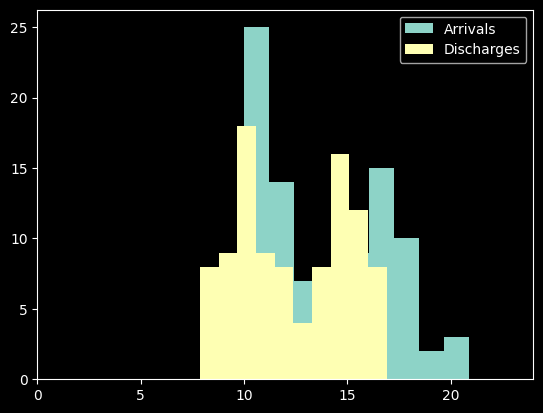

In [151]:
plt.hist(data["arrivals"], label="Arrivals")
plt.hist(data["discharges"], label="Discharges")
plt.legend()
plt.xlim(0, 24)
plt.show()

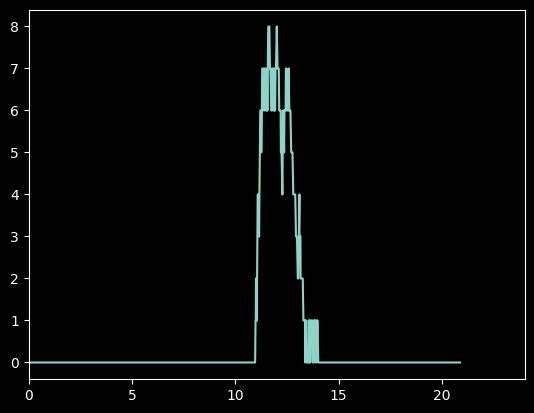

In [152]:
plt.plot(data["times"], data["demands"][1])
plt.xlim(0, 24)
plt.show()

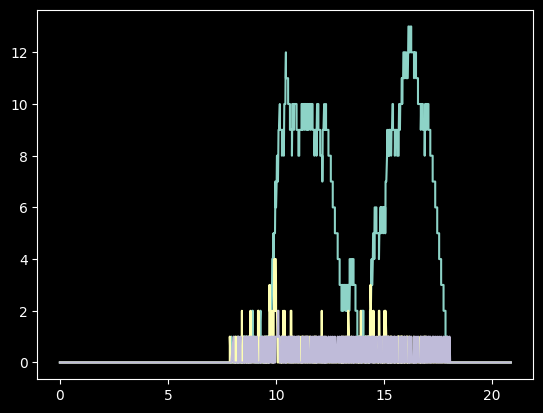

In [ ]:
for buffer in data["buffers"][Buffer.DIRTY]:
    plt.plot(data["times"], buffer)

plt.plot(data["times"], data["buffers"][Buffer.CLEAN, 0])

# Looking at distributions

Gamma mean: 125.0
Time taken @ 1.4 m/s: 125.00000000000001
[107.16561484 144.18690374]


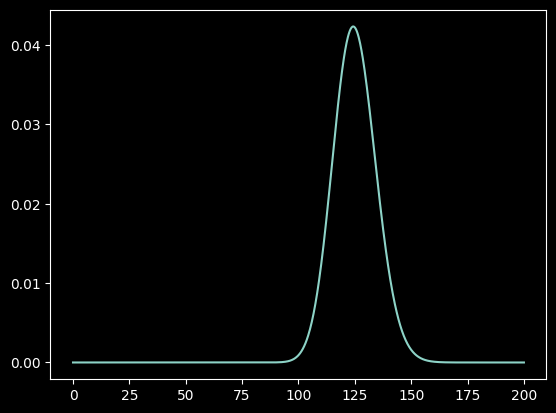

In [154]:
from scipy.stats import gamma

dist = gamma(a=175, scale=1/1.4)

t = np.linspace(0, 200, 1000)

p = dist.pdf(t)

print("Gamma mean:", dist.mean())
print("Time taken @ 1.4 m/s:", 175 / 1.4)
print(dist.ppf([0.025, 0.975]))

plt.plot(t, p)
plt.show()

Lognorm mean: 125.62656510742514
Time taken @ 1.4 m/s: 125.00000000000001
[102.7518994 152.0653155]


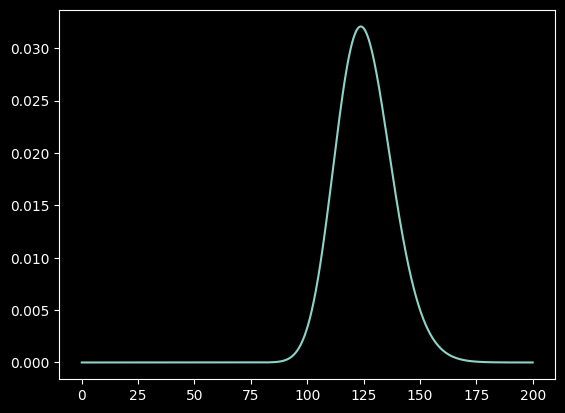

In [155]:
from scipy.stats import lognorm

dist = lognorm(s=1/10, scale=175/1.4)

t = np.linspace(0, 200, 1000)

p = dist.pdf(t)

print("Lognorm mean:", dist.mean())
print("Time taken @ 1.4 m/s:", 175 / 1.4)
print(dist.ppf([0.025, 0.975]))

plt.plot(t, p)
plt.show()